# Project 4 - Overlay Images

### Basic Idea
We want to place a new image on top of an old one seamlessly

In [56]:
%pylab inline
from PIL import Image
import numba
from scipy import ndimage

Populating the interactive namespace from numpy and matplotlib


C:\Users\camac\Miniconda3\envs\lab4\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poisson']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


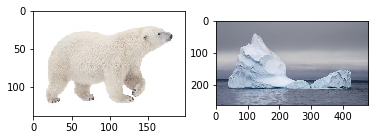

In [57]:
polarbear = array(Image.open("polarbear.jpg")).astype(np.float64)
iceberg = array(Image.open("iceberg.jpg")).astype(np.float64)
ax, fig = subplots(1, 2)
fig[0].imshow(polarbear / 255)
fig[1].imshow(iceberg / 255)

In [58]:
def dx(image):
    kernel = array([[0, 0, 0], [0, -1, 1], [0, 0, 0]])
    return np.stack([ndimage.convolve(image[:, :, channel], kernel) for channel in range(3)], axis=2)

def dy(image):
    kernel = array([[0, 0, 0], [0, -1, 0], [0, 1, 0]])
    return np.stack([ndimage.convolve(image[:, :, channel], kernel) for channel in range(3)], axis=2)

def dx2(image):
    kernel = array([[0, 0, 0], [-1, 1, 0], [0, 0, 0]])
    return np.stack([ndimage.convolve(image[:, :, channel], kernel) for channel in range(3)], axis=2)

def dy2(image):
    kernel = array([[0, -1, 0], [0, 1, 0], [0, 0, 0]])
    return np.stack([ndimage.convolve(image[:, :, channel], kernel) for channel in range(3)], axis=2)

def laplacian(image):
    kernel = array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    return np.stack([ndimage.convolve(image[:, :, channel], kernel) for channel in range(3)], axis=2)

In [59]:
def solve_poisson(image, poisson, count=10):
    height, width = image.shape[:2]
    image = image.copy().astype(np.float64)
    for n in range(count):
        image[1:-1, 1:-1] = (image[2:, 1:-1] + image[:-2, 1:-1] + image[1:-1, 2:] + image[1:-1, :-2] - poisson[1:-1, 1:-1]) / 4
    return image

@numba.njit()
def solve_poisson2(image, poisson, count=10):
    height, width = image.shape[:2]
    image = image.copy().astype(np.float64)
    for n in range(count):
        for y in range(1, height-1):
            for x in range(1, width-1):
                image[y, x] = (image[y-1, x] + image[y+1, x] + image[y, x-1] + image[y, x+1] - poisson[y, x]) / 4
    return image

In [60]:
sx_polarbear = dx(polarbear)
sy_polarbear = dy(polarbear)

sx_iceberg = dx(iceberg)
sy_iceberg = dy(iceberg)

In [73]:
paste_x, paste_y = 250, 10
polar_height, polar_width = sx_polarbear.shape[:2]
sx = sx_iceberg.copy()
sy = sy_iceberg.copy()
sx[paste_y:paste_y+polar_height, paste_x:paste_x+polar_width] = (2*sx_polarbear + 1 * sx_iceberg[paste_y:paste_y+polar_height, paste_x:paste_x+polar_width]) / 3
sy[paste_y:paste_y+polar_height, paste_x:paste_x+polar_width] = (2*sy_polarbear + 1 * sy_iceberg[paste_y:paste_y+polar_height, paste_x:paste_x+polar_width]) / 3

In [80]:
s2x = dx2(sx)
s2y = dy2(sy)
poisson = s2x + s2y

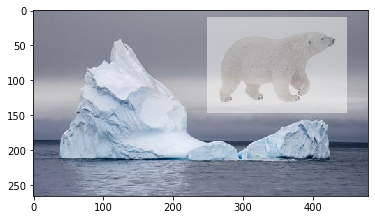

In [81]:
image = iceberg.copy()
image[paste_y:paste_y+polar_height, paste_x:paste_x+polar_width] = (polarbear + iceberg[paste_y:paste_y+polar_height, paste_x:paste_x+polar_width]) / 2
imshow(image / 255)

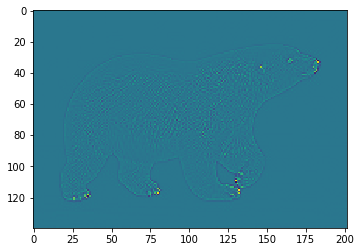

In [82]:
iterate_image = image[paste_y-1:paste_y+1+polar_height, paste_x-1:paste_x+1+polar_width]
iterate_poisson = poisson[paste_y-1:paste_y+1+polar_height, paste_x-1:paste_x+1+polar_width]
imshow(iterate_poisson[:, :, 0])

In [83]:
reconstructed = solve_poisson(iterate_image, iterate_poisson, count=8000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


199.0


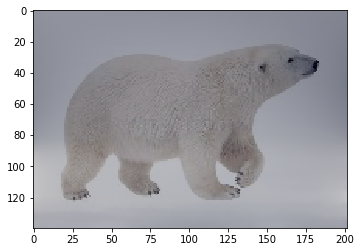

In [84]:
print(reconstructed.max())
imshow(reconstructed / 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


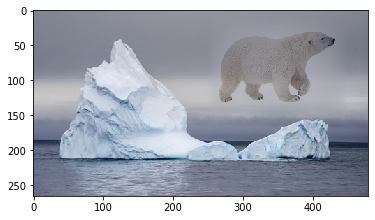

In [85]:
final_image = image.copy()
final_image[paste_y-1:paste_y+1+polar_height, paste_x-1:paste_x+1+polar_width] = reconstructed
imshow(final_image / 255)

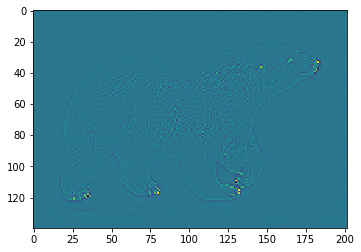

In [89]:
polarbear_laplacian = laplacian(polarbear)
iceberg_laplacian = laplacian(iceberg)
final_laplacian = iceberg_laplacian.copy()
final_laplacian[paste_y:paste_y+polar_height, paste_x:paste_x+polar_width] = (polarbear_laplacian + 2 * iceberg_laplacian[paste_y:paste_y+polar_height, paste_x:paste_x+polar_width]) / 3
iterate_image = image[paste_y-1:paste_y+1+polar_height, paste_x-1:paste_x+1+polar_width]
iterate_laplacian = final_laplacian[paste_y-1:paste_y+1+polar_height, paste_x-1:paste_x+1+polar_width]
imshow(iterate_laplacian[:, :, 0])

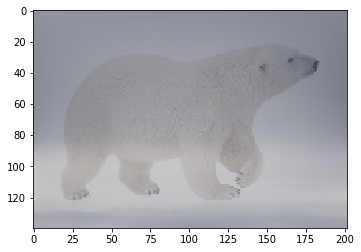

In [90]:
result = solve_poisson(iterate_image, iterate_laplacian, count=5000)
imshow(result / 255)

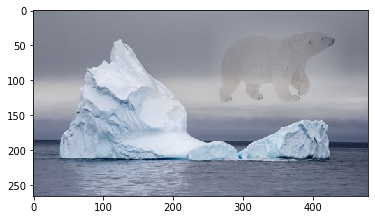

In [91]:
final_image = image.copy()
final_image[paste_y-1:paste_y+1+polar_height, paste_x-1:paste_x+1+polar_width] = result
imshow(final_image / 255)